In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation
import pandas as pd
import math


%matplotlib inline

npr.seed(0)


In [33]:
#Version 4.5.21
#Superloop for statistics
#possibility for multiple init versions
#possibility for concatenated time seris
#cross even odd validation better results for llh as an indicator (sum of llh even/odd) (AIC also based on sum llh)

# Set the parameters of the HMM
time_bins = 1000 # number of time bins
max_num_true_states = 9 # number of true states to loop over
obs_dim = 20 # data dimension (example ROIs)
num_categories = 10 # number of output types/categories (example bins of df/f)
max_num_states = 9  #until how many trial states to loop over
num_different_init_params = 1 # number of trials with different init params (in long series does not matter) 
num_loops_for_statistics = 20 #number of iterations over whole process to get statistics
num_series = 20  #How many series (of sampled data) should be concatenated


#1. AIC (not masked transmatrix),number of FREE params (each row sums to 1!!,not in smm categorial obs matrix)
#   AIC = 2ln(likelihood) - 2* num free params (--> min)
#   likelihood as hmm.log_probability(obs) is already a log

def AIC(num_states, obs_dim, num_categories, likelihood):
    
    number_params = (np.square(num_states)-num_states)+(num_states*obs_dim*num_categories)+(num_states-1)
    AIC = 2 * number_params - 2 * likelihood
    
    return AIC


#2. BIC (Bayesian integrated likelihood, with prior), see above
#   BIC = 0.5* num free params* ln(time bins/steps) - ln(likelihood) (--> min)

def BIC(num_states, obs_dim, num_categories, likelihood, time_bins):
    number_params = (np.square(num_states)-num_states)+(num_states*obs_dim*num_categories)+(num_states-1)
    BIC = (0.5 * number_params * (np.log(n))) - likelihood
    
    return BIC

#list for number of true states to superloop over
lst_number_true_states = [i+1 for i in range(1, max_num_true_states)]

#prepare list for storage
lst_lst_state_AIC = []
lst_lst_state_llh = []

#superloop over different number of true states
for i in range(len(lst_number_true_states)):   

    #make the true hmm for sampling datas
    true_hmm = ssm.HMM(lst_number_true_states[i], obs_dim, 
                   observations="categorical", observation_kwargs=dict(C=num_categories),
                   transitions="standard")

    #loop producing a list holding the sampled series for later concatenating
    lst_series_obs = []
    for i in range(num_series):
        # Sample some data from the HMM
        true_states, obs = true_hmm.sample(time_bins)
        lst_series_obs.append(obs)

    #concatenate:
    obs_conc = np.concatenate((lst_series_obs), axis = 0)
    
    #prepare for even odd separation of obs mit slicing (start:stop:step)
    obs_even = obs_conc[0:len(obs):2]
    obs_odd = obs_conc[1:len(obs):2]
    
    # Sample some data from the HMM
    true_states, obs_obs = true_hmm.sample(time_bins)

    # Compute the true log probability of the data, summing out the discrete states
    true_lp = true_hmm.log_probability(obs_conc)

    #list for number of trial states to loop over trial states
    lst_number_states = [i+1 for i in range(1, max_num_states)]
    
    #prepare the storage lists
    lst_state_AIC = []
    lst_state_llh = []


   

    #insert loop for statistics
    for i in range(num_loops_for_statistics):

        #prepare the storage lists
        dict_indicators = {}    
        lst_learned_trans_mat_odd = []
        lst_learned_trans_mat_even = []

        #insert loop over states
        for i in range(len(lst_number_states)): 

            #fit model for the even and calc the log likeliood with that model(parmas) for the odd and vice versa
            #the indicator is then the sum of these two log likelihoods (Lit: Celeux, Durand)

            #open value list for dictionary of indicators
            lst = []

            #prepare list um min für AIC im loop over init params auszurechnen    
            lst_inner_AIC = [] 
            lst_inner_sum_llh = []

            #loop for number of different init states
            for j in range(num_different_init_params):   

                N_iters = 100

                even_hmm = ssm.HMM(lst_number_states[i], obs_dim, 
                          observations="categorical", observation_kwargs=dict(C=num_categories),
                          transitions="standard")
                # Fit
                hmm_lps = even_hmm.fit(obs_even,  method="em", num_iters=N_iters, verbose = 0) 
                #lst_inner.append(even_hmm.log_likelihood(obs_odd))


                odd_hmm = ssm.HMM(lst_number_states[i], obs_dim, 
                          observations="categorical", observation_kwargs=dict(C=num_categories),
                          transitions="standard")

                # Fit
                hmm_lps = odd_hmm.fit(obs_odd,  method="em", num_iters=N_iters, verbose = 0) 

                #store sum of both (the criteria)
                sum_llh = even_hmm.log_likelihood(obs_odd) + odd_hmm.log_likelihood(obs_even)
                lst_inner_sum_llh.append(sum_llh)

                #calculate AIC from cross sum llh
                lst_inner_AIC.append(AIC(lst_number_states[i], obs_dim, num_categories, sum_llh))

                #calculate BIC from cross sum llh
                #lst_inner.append(BIC(num_states, obs_dim, num_categories, sum_llh, time_bins))


            #fill lst for dict mit dem min AIC der inner list
            lst.append(min(lst_inner_AIC))

            #fill lst for dict with max sum llh
            lst.append(max(lst_inner_sum_llh))

            #fill the list with learned transition matrix
            lst_learned_trans_mat_odd.append(odd_hmm.transitions.transition_matrix) 
            lst_learned_trans_mat_even.append(even_hmm.transitions.transition_matrix)

            #insert the list as value into dict
            dict_indicators[lst_number_states[i]] = lst


        #get lists from the dictionary to find the state with min AIC and max llh
        lst_keys = list(dict_indicators.keys())
        lst_values_tot = list(dict_indicators.values())

        #separate the AIC and the llh with a loop over lst_values_tot
        lst_AIC_values, lst_llh_values = [],[]
        for i in range(len(lst_values_tot)):
            lst_AIC_values.append(lst_values_tot[i][0])
            lst_llh_values.append(lst_values_tot[i][1])

        #find index in list with min AIC, max llh
        index_AIC = lst_AIC_values.index(min(lst_AIC_values))
        index_llh = lst_llh_values.index(max(lst_llh_values))

        #get key value at index (--> state for min AIC/max llh) and store them in list for making histogramms
        lst_state_AIC.append(lst_keys[index_AIC])
        lst_state_llh.append(lst_keys[index_llh])
        
        
    #store the lst_state_AIC/llh in the list for different number of true states
    lst_lst_state_AIC.append(lst_state_AIC)
    lst_lst_state_llh.append(lst_state_llh)


print(lst_lst_state_AIC)
print(lst_lst_state_llh)

[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3], [5, 3, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5], [5, 5, 5, 6, 5, 4, 5, 6, 4, 6, 6, 5, 4, 6, 5, 5, 5, 5, 6, 5], [5, 4, 6, 7, 5, 5, 5, 5, 6, 6, 7, 4, 5, 7, 5, 5, 6, 6, 5, 5], [6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 5, 7, 6, 7, 6], [5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 4, 6, 5, 6, 5, 5, 6, 6, 7], [5, 6, 5, 5, 6, 7, 6, 5, 5, 7, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6]]
[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3], [5, 6, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5], [5, 6, 5, 6, 5, 7, 5, 6, 7, 6, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5], [7, 8, 6, 7, 7, 6, 5, 7, 6, 8, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6], [7, 7, 6, 9, 6, 7, 6, 8, 7, 9, 6, 9, 7, 7, 7, 6, 7, 8, 7, 8], [6, 7, 6, 7, 8, 6, 7, 7, 8, 8, 7, 8, 8, 9, 7, 8, 7, 7, 8, 7], [7, 6, 7, 9, 8, 7, 9, 7, 8, 7, 8, 7, 6, 6, 8, 7, 7, 6, 6, 7]]


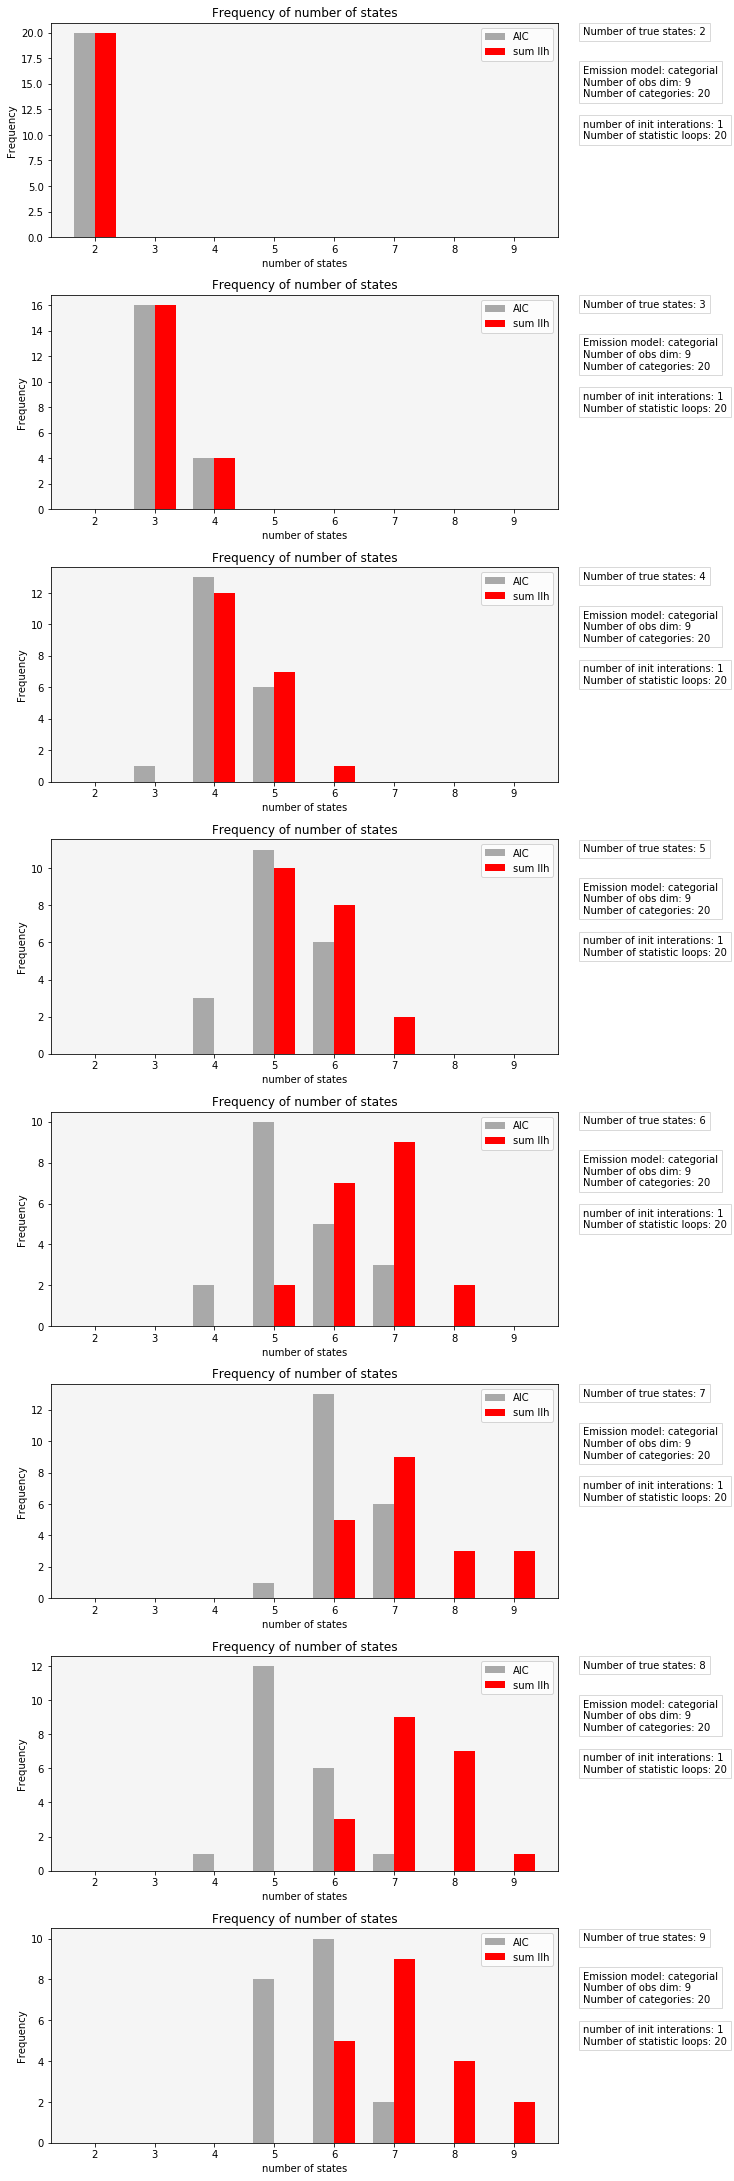

In [45]:
#bar plot for representation of the frequency of occurance of the state numbers
lst_number_true_states = [2,3,4,5,6,7,8,9]
def frequency(lst_state_x, lst_number_states ):
    
    lst_count = []
    for item in lst_number_states :
        lst_count.append(lst_state_x.count(item))
        
    return lst_count

#true state number text list generieren aus lst number true states
lst_txt0 = []
for i in range(len(lst_number_true_states)):
    lst_txt0.append('Number of true states: {}'.format(lst_number_true_states[i]))
    
    
#txt0 = 'Number of true states: {}'.format(lst_number_true_states[i])
txt = 'Emission model: categorial\nNumber of obs dim: {}\nNumber of categories: {}'.format(lst_number_true_states[i], obs_dim, num_categories) 
txt1 = 'number of init interations: {}\nNumber of statistic loops: {}'.format(num_different_init_params,num_loops_for_statistics)

x = np.arange(len(lst_number_states))  # the label locations
width = 0.35  # the width of the bars

#create flexibel subplotgrid

hight = 3.8 * len(lst_number_true_states)
fig, ax = plt.subplots(len(lst_number_true_states),1, figsize = (8,hight))

for i in range(len(lst_number_true_states)):

    ax[i].bar(x - width/2, frequency(lst_lst_state_AIC[i], lst_number_states), width, label='AIC', color = 'darkgrey')
    ax[i].bar(x + width/2, frequency(lst_lst_state_llh[i], lst_number_states), width, label='sum llh', color = 'r')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('number of states')
    ax[i].set_title('Frequency of number of states')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(lst_number_states)
    ax[i].legend()
    fig.subplots_adjust(right = 0.75) 
    ax[i].set_facecolor('whitesmoke')
    
    ax[i].text(x= 1.05, y = 0.98 ,transform=ax[i].transAxes, s = lst_txt0[i], fontsize = 10,
                       bbox=dict(facecolor= 'w', alpha=0.15),
                       horizontalalignment='left',
                       verticalalignment='top')   
    ax[i].text(x= 1.05, y = 0.8 ,transform=ax[i].transAxes, s = txt, fontsize = 10,
                       bbox=dict(facecolor= 'w', alpha=0.15),
                       horizontalalignment='left',
                       verticalalignment='top')
    ax[i].text(x= 1.05, y = 0.55 ,transform=ax[i].transAxes, s = txt1, fontsize = 10,
                       bbox=dict(facecolor= 'w', alpha=0.15),
                       horizontalalignment='left',
                       verticalalignment='top')

fig.tight_layout()
plt.savefig('cross0_super_em_4_5_21_run1.png',bbox_inches = "tight") 

plt.show()


In [38]:
#anständige Tabelle erstellen mit pandas
print(true_lp)
table = pd.DataFrame(dict_indicators, index = ['AIC', 'sum llh' ])                                        
table = table.add_prefix('states = ')

%store table
print(table)
table_transposed = table.T
print(table_transposed)

#pd.DataFrame(dict_indicators, index = ['Number of iterations', 'Log likelihood', 'AIC', 'Accuracy']).T

-784487.7406991562
Stored 'table' (DataFrame)
           states = 2    states = 3    states = 4    states = 5    states = 6  \
AIC      89620.203347  89030.080703  87906.793962  87632.847715  87433.462279   
sum llh -44407.101674 -43907.040352 -43138.396981 -42792.423858 -42481.731140   

           states = 7    states = 8    states = 9  
AIC      87628.515986  88865.381279  89719.531388  
sum llh -42366.257993 -42769.690639 -42979.765694  
                     AIC       sum llh
states = 2  89620.203347 -44407.101674
states = 3  89030.080703 -43907.040352
states = 4  87906.793962 -43138.396981
states = 5  87632.847715 -42792.423858
states = 6  87433.462279 -42481.731140
states = 7  87628.515986 -42366.257993
states = 8  88865.381279 -42769.690639
states = 9  89719.531388 -42979.765694


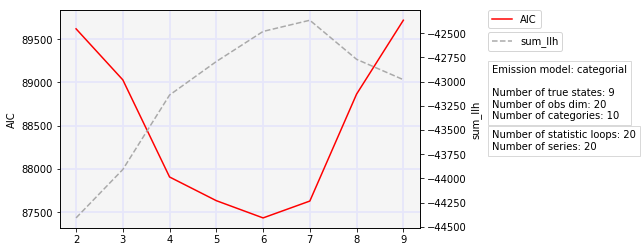

In [46]:
#bis jetzt nur Zugriff auf den letzten run (höchste number of true states), diese wird hier bestimmt
num_highest_true_state = lst_number_true_states[-1]

lst_y = [np.asarray(table.iloc[0].values),np.asarray(table.iloc[1].values) ]
label_y = ['AIC', 'sum_llh']
txt = 'Emission model: categorial\n\nNumber of true states: {}\nNumber of obs dim: {}\nNumber of categories: {}'.format(num_highest_true_state, obs_dim, num_categories) 
txt1 = 'Number of statistic loops: {}\nNumber of series: {}'.format(num_loops_for_statistics, num_series)


x = lst_number_states


fig, ax1 = plt.subplots(1,  figsize=(8,4))  
ax1.plot(x,lst_y[0], color = 'r',  label = label_y[0])
ax1.set_ylabel(label_y[0])
ax1.legend(bbox_to_anchor = (1.19,1), loc = 2, borderaxespad = 0.0)
ax1.text(x= 1.2, y = 0.75 ,transform=ax1.transAxes, s = txt, fontsize = 10,
                   bbox=dict(facecolor= 'w', alpha=0.15),
                   horizontalalignment='left',
                   verticalalignment='top')
ax1.text(x= 1.2, y = 0.45 ,transform=ax1.transAxes, s = txt1, fontsize = 10,
                   bbox=dict(facecolor= 'w', alpha=0.15),
                   horizontalalignment='left',
                   verticalalignment='top')
ax1.grid(color = 'lavender', which = 'both', linestyle = '-', linewidth = 1.8)        
ax1.set_facecolor('whitesmoke')
fig.subplots_adjust(right = 0.75)

ax2 = ax1.twinx()
ax2.plot(x,lst_y[1], color = 'darkgrey', linestyle = '--', label = label_y[1])
ax2.set_ylabel(label_y[1])
ax2.legend(bbox_to_anchor = (1.19,0.9), loc = 2, borderaxespad = 0.0)

plt.savefig('cross1_super_em_4_5_21_run1.png',bbox_inches = "tight")   
plt.show()

True Transition Matrix:
[[8.31048154e-01 3.17636481e-02 1.94699500e-02 2.71235632e-02
  6.91830630e-03 2.08190219e-02 1.45491767e-02 2.61923808e-02
  2.21157989e-02]
 [3.34337107e-02 8.27998332e-01 1.46837267e-02 1.89876239e-02
  6.73523356e-03 3.32022293e-02 2.75587707e-02 9.30103808e-03
  2.80993351e-02]
 [2.80377643e-02 2.90661519e-02 8.00829075e-01 2.52886511e-02
  1.27437665e-02 1.98667986e-02 1.62425005e-02 3.86037652e-02
  2.93215265e-02]
 [4.13648865e-02 2.54518265e-02 1.51703196e-02 8.28234204e-01
  1.00288746e-02 2.83355687e-02 3.33995377e-02 7.25805620e-03
  1.07567263e-02]
 [2.42742096e-02 2.01442562e-03 2.91782993e-02 2.70752483e-02
  8.04695768e-01 2.30078421e-02 3.88390992e-02 3.41550692e-02
  1.67600390e-02]
 [1.52991881e-02 2.29835313e-02 1.75331132e-02 9.78660044e-03
  1.75154398e-02 8.72503277e-01 2.60445619e-02 1.59165184e-03
  1.67426364e-02]
 [3.85952234e-02 1.83862221e-02 1.41300971e-02 3.61485127e-02
  1.69117862e-02 3.09626026e-02 8.29323161e-01 1.23534337e-02


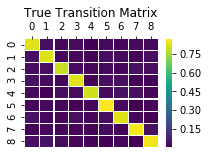

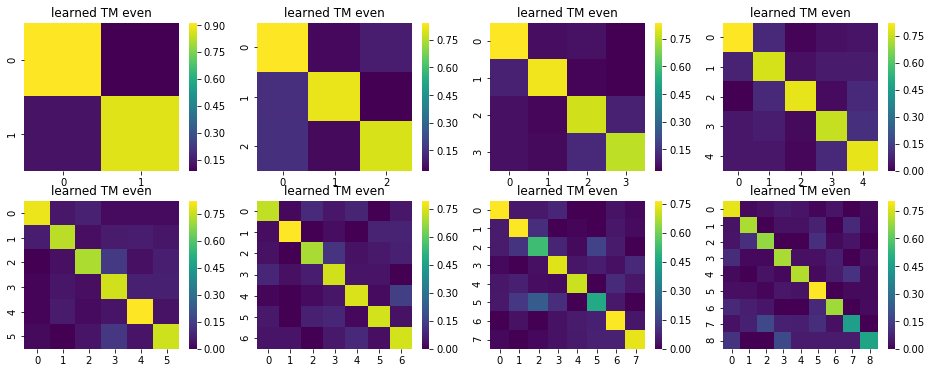

In [43]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = even_hmm.transitions.transition_matrix

print('True Transition Matrix:')
print(true_transition_mat)


fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(true_transition_mat, ax = ax,   
                     linewidth=0.1, cmap = 'viridis')

ax.set_title('True Transition Matrix', y = 1.2 ,transform=ax.transAxes)
ax.xaxis.set_ticks_position('top')

#datas for the plot loop
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(16,6))

for i in lst_learned_trans_mat_even:
    plt.subplot(a, b, c)
    plt.title('learned TM even')
    plt.ylabel('number of states')
    sns.heatmap(i,cmap = 'viridis')
    c = c + 1

plt.show()


True Transition Matrix:
[[8.31048154e-01 3.17636481e-02 1.94699500e-02 2.71235632e-02
  6.91830630e-03 2.08190219e-02 1.45491767e-02 2.61923808e-02
  2.21157989e-02]
 [3.34337107e-02 8.27998332e-01 1.46837267e-02 1.89876239e-02
  6.73523356e-03 3.32022293e-02 2.75587707e-02 9.30103808e-03
  2.80993351e-02]
 [2.80377643e-02 2.90661519e-02 8.00829075e-01 2.52886511e-02
  1.27437665e-02 1.98667986e-02 1.62425005e-02 3.86037652e-02
  2.93215265e-02]
 [4.13648865e-02 2.54518265e-02 1.51703196e-02 8.28234204e-01
  1.00288746e-02 2.83355687e-02 3.33995377e-02 7.25805620e-03
  1.07567263e-02]
 [2.42742096e-02 2.01442562e-03 2.91782993e-02 2.70752483e-02
  8.04695768e-01 2.30078421e-02 3.88390992e-02 3.41550692e-02
  1.67600390e-02]
 [1.52991881e-02 2.29835313e-02 1.75331132e-02 9.78660044e-03
  1.75154398e-02 8.72503277e-01 2.60445619e-02 1.59165184e-03
  1.67426364e-02]
 [3.85952234e-02 1.83862221e-02 1.41300971e-02 3.61485127e-02
  1.69117862e-02 3.09626026e-02 8.29323161e-01 1.23534337e-02


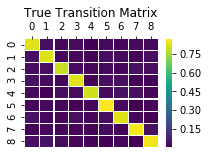

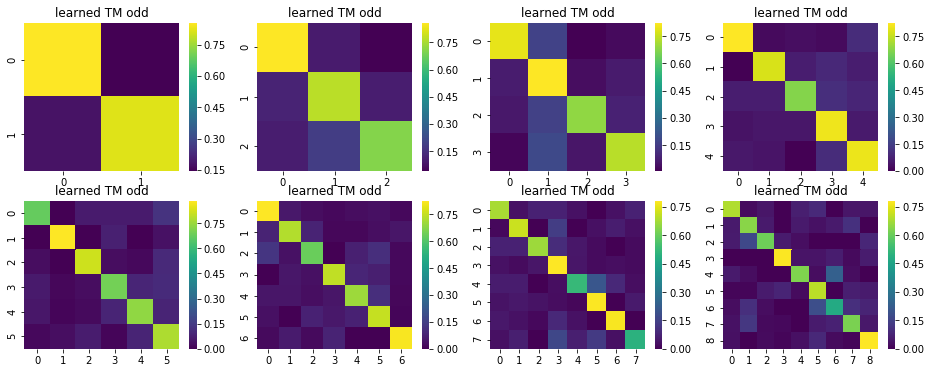

In [44]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = odd_hmm.transitions.transition_matrix

print('True Transition Matrix:')
print(true_transition_mat)


fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(true_transition_mat, ax = ax,   
                     linewidth=0.1, cmap = 'viridis')

ax.set_title('True Transition Matrix', y = 1.2 ,transform=ax.transAxes)
ax.xaxis.set_ticks_position('top')

#datas for the plot loop
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(16,6))

for i in lst_learned_trans_mat_odd:
    plt.subplot(a, b, c)
    plt.title('learned TM odd')
    plt.ylabel('number of states')
    sns.heatmap(i,cmap = 'viridis')
    c = c + 1

plt.show()


In [88]:
print(dict_indicators)
print()
k = list(dict_indicators.keys())
l = list(dict_indicators.values())



l_AIC, l_llh = [],[]
for i in range(len(l)):
    l_AIC.append(l[i][0])
    l_llh.append(l[i][1])
    
index_AIC = l_AIC.index(min(l_AIC))
index_llh = l_llh.index(max(l_llh))

print(index_AIC)
print(index_llh)
print(k[index_AIC])
print(k[index_llh])

{2: [39744.649289068846, -19709.324644534423], 3: [39279.635327221375, -19391.817663610687], 4: [38973.98648575255, -19151.993242876277], 5: [38801.20268372937, -18976.601341864683], 6: [38880.46650291124, -18925.23325145562], 7: [38979.183649718005, -18881.591824859002], 8: [39581.61316097164, -19087.80658048582], 9: [39922.04329811745, -19161.021649058726]}

3
5
5
7


In [24]:
print(lst_lst_state_AIC[0])
print(lst_lst_state_llh[1])

def frequency(lst_state_x, lst_number_states ):
    
    lst_count = []
    for item in lst_number_states :
        lst_count.append(lst_state_x.count(item))
        
    return lst_count 

print(frequency(lst_lst_state_AIC[0],lst_number_states ))
print(frequency(lst_lst_state_llh[1],lst_number_states ))


[6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6]
[0, 0, 0, 29, 11, 0, 0, 0]
[0, 0, 0, 0, 36, 4, 0, 0]
